# Equation-Informed Neural Networks Tutorial
## Introduction: One-Dimensional Advection-Diffusion Equation

The advection–diffusion equation is a combination of the diffusion and convection (advection) equations, and describes physical phenomena where particles, energy, or other physical quantities are transferred inside a physical system due to two processes: **diffusion** and **convection**. Depending on context, the same equation can be called the convection–diffusion equation, drift–diffusion equation, or (generic) scalar transport equation. In one-dimension, the simplified transient form of the equation can be written as the following

$$
\frac{\partial u}{\partial t} = D\frac{\partial^2 u}{{\partial x}^2} - V\frac{\partial u}{\partial x} + S,
$$
where
- $u = u(t,x)$ is the quantity of interest (e.g., pollutant concentration for mass transfer, temperature for heat transfer).
- $D$ is the diffusivity (also called diffusion coefficient), such as mass diffusivity for particle motion or thermal diffusivity for heat transport.
- $V$ is the velocity magnitude that the quantity is moving with. In general, it is a function of time and space, but for simplicity we assume it is a constant value.
- $S = S(t,x)$ describes sources or sinks of the quantity $u$. For example, for chemical species, $S > 0$ means that a chemical reaction is creating more of the species.

## Quick Theory on Equation-informed Deep Learning

To address the above problem, we consider constructing a deep neural network that returns predictions constrained by the parametrized partial differential equation in the following form

$$
{u}_t - D u_{xx} + V u_x - S = 0,
$$
where $u(t,x)$ is represented by a deep neural network parametrized by a set of parameters $\theta$ i.e., $u(t, x) = f_{\theta}(t,x)$, where $x$ is a vector of space coordinates and $t$ is the time coordinate. As neural networks are differentiable representations, this construction defines a so-called *equation-informed neural network* that corresponds to the PDE residual i.e.,
$$r_{\theta}(t,x):= \frac{\partial}{\partial t}f_{\theta}(t,x) - D\frac{\partial^2 }{{\partial x}^2}f_{\theta}(t,x) + V\frac{\partial}{\partial x}f_{\theta}(t,x) - S(t,x).$$
The resulting training procedure allows us to recover the shared network parameters $\theta$ using a few scattered **observations** of $u(t,x)$, namely
$$\{(t_i, x_i), u_i\}, \ \ i = 1,\dots,N_u,$$
along with a larger number of residual points,
$$\{(t_i, x_i), r_i\}, \ \ i = 1,\dots,N_r,$$
that aim to penalize the **PDE residual** at a finite set of $N_r$ residual points. The data for the residuals are typically zero (i.e., $r_i = 0$), or they may correspond to external forcing terms evaluated at the corresponding location e.g., $S(t_i, x_i), \, i=1,\dots,N_r$.

The resulting optimization problem can be effectively solved using standard stochastic gradient descent without necessitating any elaborate constrained optimization techniques, simply by minimizing the composite loss function
$$\mathcal{L}(\theta) = \frac{1}{N_u}\sum\limits_{i=1}^{N_u}\|f_{\theta}(t_i, x_i) - {u}_i\|^2 + \frac{1}{N_r}\sum\limits_{i=1}^{N_r}\|r_{\theta}(t_i, x_i) - {r}_i\|^2,$$
where the required gradients $\partial \mathcal{L}/\partial \theta$ can be readily obtained using automatic differentiation.

---
<img src="./figures/AD-Architecture.PNG" alt="drawing" width="600"/>

---

### Application as a PDE solver
Numerical solution of a PDE requires the imposition of proper boundary and initial conditions. This can be easily achieved by including the boundary and initial conditions as observations given at $N_u$ points. Thus, they will contribute to the first term in the loss function. In addition, the equation residual is minimized on an arbitrary set of $N_r$ residual points. No data are required to be provided at these points.

### Application in a data-driven inverse problem
Inverse problems arise in many areas such as sensitivity analysis and system identification. Assume that we are given a few noisy observations of $u(t,x)$ and we are interested to know the solution $u(t,x)$ that governs the data. In addition, the parameters of the system such as $D$ and $V$ are unknown and we would like to identify those as part of the learning process to find $u$. In this tutorial, we investigate both applications for the advection-diffusion problem.

In all cases pertaining to data-driven solution of partial differential equations, the total number of training data $N_u$ is relatively small. Despite the fact that there is no theoretical guarantee that this procedure converges to a global minimum, the empirical evidence indicates that, if the given partial differential equation is well-posed and its solution is unique, the method is capable of achieving good prediction accuracy given a sufficiently expressive neural network architecture and a sufficient number of residual points $N_r$.

### Limitation
As noted above, we are seeking for a (data-driven) solution of the PDE in a specified bounded domain. This solution is **unique**, thus, the concept of generaliztion to other solutions is meaningless in this context. However, extending or extrapolating the solution out of the specified domain is possible, but not discussed here.

---
---

## Define the Problem and Solve the PDE to Generate Synthetic Data

Frist, we need to define the problem including the time and space domain, boundary and initial conditions and generate data synthetically using a separate PDE numerical solver. Synthetically generated data are useful for training and validation of machine learning algorithms in the absence of real observations.

The problem we aim to address is the advection-diffusion equation rewritten in the non-dimensional form

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{{\partial x}^2} - \mathrm{Pec} \frac{\partial u}{\partial x} + \mathrm{Pec} \, S,
$$
where $\mathrm{Pec} = \frac{VL}{D}$ is called the `Peclet` number, which indicates the relative strength of advection to diffusion; higher `Pec` values mean stronger advection compared to diffusion. The advantage of rewriting equations in non-dimensional form is grouping parameters of the equations into a single parameter. We consider $\mathrm{Pec} = 3.0$ in this tutorial. Note that, in non-dimensional form, the space domain length is always one i.e., $x \in [0, 1]$. Also, time is unitless and we choose time range long enough so the solution becomes steady-state (time independent). We solve the problem in a general transient form i.e., $u=u(t,x)$ starting from an initial condition $u(0,x)$, however, the steady-state can be reached as time passes by i.e., $u \approx u(x)$ as $t \rightarrow \infty$. The source term $S(t,x)$ is assummed to be a function of space and equal to $S(x)=5 \, \sin(2\pi x)$, however, other source functions can be considered with no restriction.

The boundary conditions that are considered here are simply $u(t,0) = u(t,L) = 0$ at all times. As for initial condition, we assume $u(0,x) = \cos(2\pi x)-1$ everywhere in the domain, which leads to initial transient behavior that settles into a steady-state behavior later. The above equation can be solved numerically by the method of finite difference using different packages in Python. The package [py-pde](https://py-pde.readthedocs.io/en/latest/getting_started.html) was selected here due to its ease of use.

In [1]:
import numpy as np
import numpy.random as npr
from math import pi

import tensorflow as tf

# !pip install py-pde
from pde import CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph, PlotTracker
from pde.tools.numba import jit

import matplotlib.pyplot as plt

from tqdm import trange
npr.seed(1234)
tf.random.set_seed(1234)

""" Class of PDE solver using finite difference method to generate synthetic data for 
training and validation """
class AdvectionDiffusion1dPDE(PDEBase):
    def __init__(self, Pec, source, bc='natural'):
        """ initialize the class with a Peclet number and boundary conditions
        for the solution field """
        self.Pec = Pec
        self.source = source
        self.bc = bc
        
    def evolution_rate(self, state, t=0):
        """ numpy implementation of the evolution equation """
        assert state.grid.dim == 1              # ensure the state is one-dimensional
        x = state.grid.cell_coords.squeeze()
        state_lapacian = state.laplace(bc=self.bc)
        state_gradient = state.gradient(bc=self.bc)
        return state_lapacian - self.Pec*state_gradient + self.Pec*self.source(x)

    def _make_pde_rhs_numba(self, state):
        """ the numba-accelerated evolution equation """
        assert state.grid.dim == 1              # ensure the state is one-dimensional
        """ make class attributes locally available """
        Pec = self.Pec
        x = state.grid.cell_coords.squeeze()
        s = self.source(x)
        
        """ create operators """
        laplace_u = state.grid.get_operator('laplace', bc=self.bc)
        gradient_u = state.grid.get_operator('gradient', bc=self.bc)

        @jit
        def pde_rhs(state_data, t=0):
            """ compiled helper function evaluating right hand side """
            state_lapacian = laplace_u(state_data)
            state_gradient = gradient_u(state_data)
            return state_lapacian - Pec*state_gradient + Pec*s
        return pde_rhs

### Generate train and test data for the model
Note that the use of mathematical expressions is facilitated by [sympy](https://www.sympy.org/en/index.html) package. We only use it here to parse the expressions into NumPy semantics.

In [2]:
""" Class that contains physical parameters, true solution of the PDE as well as 
training and validation datasets """
class Data(object):
    def __init__(self, param):
        """ initialize the class with model parameters and initialize the external PDE solver """
        self.mode   = param['mode']
        self.d_x    = param['d_x']
        self.L      = self.d_x[1] - self.d_x[0]
        self.d_t    = param['d_t']
        self.T      = self.d_t[1] - self.d_t[0]
        self.Pec    = param['Pec']
        self.n_icbc = param['n_icbc']        # number of boundary/initial conditions 
        self.n_data = param['n_data']        # number of data points on u(t,x) + noise in the 'inverse' mode
        self.n_res  = param['n_res']         # number of residual (collocation) points for minimizing the PDE residual
        self.f_init = param['f_init']        # function for the initial condition (in sympy semantic)
        self.n_x    = param['n_test'][0]     # number of test data for validating the model predictions: along x
        self.n_t    = param['n_test'][1]     # number of test data for validating the model predictions: along t
        self.noise  = param['noise']         # level of the noise added to the data in the 'inverse' mode
        self.s      = param['s']             # define source term
        self.s_tf   = param['s_tf']          # define source term (in Tensorflow semantic)
        
        if self.mode != 'solver' and self.mode != 'inverse':
            raise ValueError('Mode can only be "solver" or "inverse"!')
        assert self.n_data <= self.n_x*self.n_t          # data points are sampled from true solution
        assert self.L > 0
        assert self.T > 0
        
        """ external PDE solver """
        self.pde = AdvectionDiffusion1dPDE(Pec=self.Pec,
                                           source=self.s,
                                           bc=[{'type': 'value', 'value': 0}, {'type': 'value', 'value': 0}]
                                          )
        
    """ get the PDE solution for validation """
    def get_pde_solution(self):
        lb  = self.d_x[0]         # left boundary of the domain
        ub  = self.d_x[1]         # right boundary of the domain
        t0  = self.d_t[0]         # set initial time to zero
        t1  = self.d_t[1]         # set final time to T
        n_x = self.n_x            # n_x spatial points for testing
        n_t = self.n_t            # n_t time steps for testing
        
        grid = CartesianGrid([[lb, ub]], [n_x], periodic=False)                         # generate the grid with n_x points
        state = ScalarField.from_expression(grid, self.f_init, label='u(t, x)')         # initialize the field with the initial condition
        storage = MemoryStorage()
        trackers = [
            'progress',                                             # show progress bar during simulation
            storage.tracker(interval=(t1-t0)/n_t),                  # store data every simulation time unit
            PlotTracker(show=True, interval=2*(t1-t0)/n_t),         # show images during simulation
        ]
        
        """ generate validation data: solve the PDE using another solver """
        self.pde.solve(state, t_range=t1, tracker=trackers)         # solve the PDE and store the result for validation
    
        """ extract true solution from the solver and store them """
        t = []
        u = []
        for time, field in storage.items():
            t.append(time)
            u.append(field.data)
        self.t_test = np.array(t).reshape(-1, 1)     
        self.x_test = grid.cell_coords               
        self.u_true = np.vstack(u)
        return
    
    """ prepare training and validation data for the inverse and sovler modes """
    def prep_data(self):
        lb = np.array([self.d_x[0]])         # left boundary of the domain
        ub = np.array([self.d_x[1]])         # right boundary of the domain
        t0 = np.array([self.d_t[0]])         # set initial time to zero
        t1 = np.array([self.d_t[1]])         # set final time to T
        
        """ generate training data: initial and boundary conditions """
        t_d = np.linspace(t0, t1, self.n_icbc)
        x_d = np.linspace(lb, ub, self.n_icbc)
        tt, xx = np.meshgrid(t_d, x_d, sparse=False, indexing='ij')
        """ we only need the boundary points be given as training data in 'solver' mode """
        t_ic = tt[tt==0]                            # initial condition is at t=0
        x_ic = xx[tt==0]                            # x values at t=0
        u_ic = np.cos(2*pi*x_ic) - 1                # initial condition at time t=0
        t_bc = tt[(xx==lb) | (xx==ub)]              # time at the boundaries
        x_bc = xx[(xx==lb) | (xx==ub)]              # boundaries are at x=lb and x=ub
        u_bc = np.zeros(x_bc.shape[0])              # solution u at the boundaries is considered to be 0

        t_icbc = np.concatenate([t_ic, t_bc]).reshape(-1, 1)
        x_icbc = np.concatenate([x_ic, x_bc]).reshape(-1, 1)
        u_icbc = np.concatenate([u_ic, u_bc]).reshape(-1, 1)

        """ generate training data: residual points for PDE """
        n_grid = int(np.sqrt(self.n_res)+10)
        t_r  = np.linspace(t0, t1, n_grid)                                   # location of temporal collocation points for PDE residual
        x_r  = np.linspace(lb, ub, n_grid)                                   # location of spatial collocation points for PDE residual
        tt, xx = np.meshgrid(t_r, x_r, sparse=False, indexing='ij')
        """ sample t, x and u for the PDE residual """
        idx = npr.choice(n_grid**2, self.n_res, replace=False)
        self.t_res = tt.flatten()[idx].reshape(-1, 1)
        self.x_res = xx.flatten()[idx].reshape(-1, 1)
        self.u_res = np.zeros(self.x_res.shape)                              # PDE residual target values are 0

        """ generate training data: interior data points for 'inverse' mode """
        """ select randomly n_data from the synthetic data as u(t,x) and add noise to it """
        t_size = self.t_test.shape[0]
        x_size = self.x_test.shape[0]

        """ sample t, x and u from the data """
        tt, xx = np.meshgrid(self.t_test, self.x_test, sparse=False, indexing='ij')
        idx = npr.choice(t_size*x_size, self.n_data, replace=False)
        t_data = tt.flatten()[idx].reshape(-1, 1)
        x_data = xx.flatten()[idx].reshape(-1, 1)
        u_data = self.u_true.flatten()[idx].reshape(-1, 1)
        u_data += npr.normal(0.0, self.noise*np.std(u_data), u_data.shape)    # add noise to the solution
        
        if self.mode == 'solver':
            self.t_data = t_icbc
            self.x_data = x_icbc
            self.u_data = u_icbc
        else:
            self.t_data = t_data
            self.x_data = x_data
            self.u_data = u_data

In [3]:
""" define the parameter set for train and test data generation """
param_dict = {
    'mode'  : 'solver',
    'd_x'   : [0., 1.0],                    # bounds of x
    'd_t'   : [0., 0.6],                    # bounds of time
    'Pec'   : 3.0,                          # Peclet in the PDE; "solver": known; "inverse": unknown
    'n_icbc': 48,                           # number of boundary points for training
    'n_data': 256,                          # number of interior points for training
    'n_res' : 1024,                         # number of residual points to enforce the PDE on
    'f_init': 'cos(2*pi*x)-1',              # initial condition function in 'sympy' semantic
    'n_test': [32, 30],                     # number of test points [n_x, n_t] in space-time domain for validation
    's'     : lambda x: 5*np.sin(2*pi*x),   # source function in the PDE
    's_tf'  : tf.autograph.experimental.do_not_convert(lambda x: 5*tf.sin(2*pi*x)),
    'noise' : 0.25                          # level of noise in the training data in "inverse" mode
}

data = Data(param_dict)

---
## Model Implementation
### Setup Dense Layers and Feed-forward Neural Network

In [4]:
""" Subclass linear dense layers from tf.Module """
class Dense(tf.Module):
    def __init__(self, input_dim, output_dim, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([input_dim, output_dim]), name=f'weights_{name}')
        self.b = tf.Variable(tf.zeros([output_dim]), name=f'biases_{name}')
        
    """ affine operation """
    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b
    
""" Define a multilayer perceptron using dense layers """
class MLP(tf.Module):
    def __init__(self, input_size, output_size, hidden_sizes, name=None):
        super().__init__(name=name)
        self.layers = []
        i = 1
        with self.name_scope:
            for size in hidden_sizes:
                self.layers.append(Dense(input_dim=input_size, output_dim=size, name=f'layer_{i}'))        # linear layer
                self.layers.append(tf.nn.softplus)                                                         # softplus activation function
                input_size = size
                i += 1
            self.layers.append(Dense(input_dim=input_size, output_dim=output_size, name='layer_output'))    # output layer with no activation

    """ add the static form of function call to the graph """
    @tf.function
    def __call__(self, t, x):
        z = tf.concat([t, x], axis=-1)
        for layer in self.layers:
            z = layer(z)
        return z

### Setup equation-informed neural network based on advection-diffusion equation

In [5]:
""" Class that defines the adv-diff problem and initializes the parmeters.
It also includes the training loop and inference """
class AdvDiff1dNN():
    def __init__(self, data, layers, loss_coeff):
        self.mode = data.mode                                     # 'solver' or 'inverse'
        self.s    = data.s_tf                                     # source term in the PDE

        self.Tscale = data.T                                      # time scale factor
        """ data points: initial & boundary conditions in 'solver' mode
        random noisy data in 'inverse' mode """
        t_dat = data.t_data / self.Tscale                         # scale t into [0, 1]
        x_dat = data.x_data
        u_dat = data.u_data
        """ residual points used in both modes """
        t_res = data.t_res / self.Tscale
        x_res = data.x_res
        u_res = data.u_res
        
        if self.mode == 'solver':
            self.Pec = tf.constant(data.Pec)                      # Peclet is a known parameter of PDE
        else:
            self.Pec = tf.Variable(0.01, name='Pec_unknown')      # Peclet is not known and can be inferred by the model
            self.Pec.assign(tf.nn.relu(self.Pec))                 # ensure Pec remains a positive number during training
    
        """ normalize data: x and u """
        self.Xmean, self.Xstd = x_res.mean(), x_res.std()
        self.Umean, self.Ustd = u_dat.mean(), u_dat.std()
        x_dat = (x_dat-self.Xmean) / self.Xstd
        x_res = (x_res-self.Xmean) / self.Xstd
        u_dat = (u_dat-self.Umean) / self.Ustd
        
        """ coefficients to give each loss term proper weight in 
        the total loss (improves the optimization speed) """
        self.alpha = tf.constant(loss_coeff[0])
        self.beta  = tf.constant(loss_coeff[1])

        """ stack and store normalized training data in two separate arrays """
        self.txu_d = np.hstack([t_dat.astype(np.float32),
                                x_dat.astype(np.float32),
                                u_dat.astype(np.float32)]
                              )
        self.txu_r = np.hstack([t_res.astype(np.float32),
                                x_res.astype(np.float32),
                                u_res.astype(np.float32)]
                              )

        """ set up network initialization and evaluation functions """
        self.layers = layers
        self.Unet   = MLP(input_size=layers[0], output_size=layers[-1], hidden_sizes=layers[1:-1], name='Unet')
        
        self.variables = self.Unet.trainable_variables
        if self.mode == 'inverse':
            self.variables = (*self.variables, self.Pec)
        print('Trainable parameters:')
        print('===================================')
        for var in self.variables:
            print(var.name, ', shape:', list(var.shape))
        print('\n')
        
        """ use tf optimizers to set optimizer initialization and learning rate scheduler """
        initial_lr = 1e-3
        self.opt = tf.optimizers.Adam(lr=initial_lr)
        self.lr_scheduler = tf.optimizers.schedules.ExponentialDecay(initial_lr,
                                                                     decay_steps=100,
                                                                     decay_rate=0.75,
                                                                     staircase=True)
        """ define mean squared error loss """
        self.MSE = tf.losses.MeanSquaredError()

        """ logger to monitor the loss function """
        self.loss_dat_log = []
        self.loss_res_log = []

    """ forward pass for u """
    def forward_U(self, t, x):
        return self.Unet(t, x)
    
    """ forward pass for PDE residual """
    def forward_R(self, t, x):
        with tf.GradientTape(persistent=True) as tape2:
            """ ensure that tensors t and x are traced by the gradient tape """
            tape2.watch(t)
            tape2.watch(x)
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch(t)
                tape1.watch(x)
                u = self.forward_U(t, x)
            """ take 1st derivative with respect to t and x """
            u_t = tape1.gradient(u, t) * self.Ustd / self.Tscale    # ensure that the equation is mathematically consistent after normalization of data
            u_x = tape1.gradient(u, x) * self.Ustd / self.Xstd                     
        """ take 2nd derivative with respect to x """
        u_xx = tape2.gradient(u_x, x) / self.Xstd
        """ compute the equation residual using the derivatives """
        residual = u_t - u_xx + self.Pec*u_x - \
                   self.Pec*self.s(x*self.Xstd+self.Xmean)
        return residual

    """ eager execution is turned on by default in TensorFlow 2
    decorating with tf.function allows TensorFlow to build a static graph out of the logic and computations in the function
    this provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one """
    @tf.function
    def loss(self, batch):
        txu_d, txu_r = batch
        loss_d = self.MSE(tf.convert_to_tensor(txu_d[:,2:3]),
                          self.forward_U(tf.convert_to_tensor(txu_d[:,0:1]),
                                         tf.convert_to_tensor(txu_d[:,1:2])))   # compute MSE loss of the data
        loss_r = self.MSE(tf.convert_to_tensor(txu_r[:,2:3]),
                          self.forward_R(tf.convert_to_tensor(txu_r[:,0:1]),
                                         tf.convert_to_tensor(txu_r[:,1:2])))   # compute MSE loss of the PDE residual (u_r=0)
        return loss_d, loss_r

    """ training data generator, validation will be done at the end of training """
    def data_stream(self, num_batches, batch_size):
        rng = npr.default_rng()
        while True:
            for i in range(num_batches):
                """ take one batch every iteration; every batch includes 
                training data + residual points for the PDE """
                yield rng.choice(self.txu_d, batch_size//2, replace=False, axis=0), \
                      rng.choice(self.txu_r, batch_size//2, replace=False, axis=0)
    
    """ training loop """
    def train(self, num_epochs=100, batch_size=64):
        n_d = self.txu_d.shape[0]
        n_r = self.txu_r.shape[0]
        num_complete_batches, leftover = divmod(n_d+n_r, batch_size)
        num_batches = num_complete_batches + bool(leftover)
        assert (n_d>=batch_size//2) & (n_r>=batch_size//2)            # make sure in every batch there are enough data and residual points
        batches = self.data_stream(num_batches, batch_size)
        
        pbar = trange(num_epochs)
        for epoch in pbar:
            loss_dat = 0.
            loss_res = 0.
            loss_tot = 0.
            for _ in range(num_batches):
                batch = next(batches)
                """ record computation of the loss on tape """
                with tf.GradientTape(persistent=True) as tape:
                    loss_d, loss_r = self.loss(batch)                  # forward pass to compute the losses for each minibatch
                    loss_t = self.alpha*loss_d + self.beta*loss_r      # combine the data loss and equation loss
                grads = tape.gradient(loss_t, self.variables)          # take gradient of total loss
                self.opt.apply_gradients(zip(grads, self.variables))   # back-propagate the gradients to update model parameters using Adam optimizer
                loss_dat += loss_d
                loss_res += loss_r
                loss_tot += loss_t
            pbar.set_postfix({'Total Loss': loss_tot.numpy()/num_batches})
            self.loss_dat_log.append(loss_dat.numpy()/num_batches)      # record the MSE of data after each epoch
            self.loss_res_log.append(loss_res.numpy()/num_batches)      # record the MSE of PDE residual after each epoch
            self.lr_scheduler(epoch)                                    # apply the lr scheduling after each epoch
    
    """ infer solution at test points """
    def predict_U(self, t_pred, x_pred):
        """ scale t and normalize x """
        t_pred = t_pred.astype(np.float32) / self.Tscale
        x_pred = (x_pred.astype(np.float32)-self.Xmean) / self.Xstd
        u_pred = self.forward_U(tf.convert_to_tensor(t_pred), tf.convert_to_tensor(x_pred))    # compute u(t, x) using trained model
        u_pred = u_pred*self.Ustd + self.Umean                                                 # make sure u(t, x) is scaled back from normalized values
        return u_pred.numpy()

---
---
## Model Experimentation
### Using model as a solver

  0%|          | 0/0.6 [00:00<?, ?it/s]

Output()

Spent more time on handling trackers (2.271601999999996) than on the actual simulation (0.35726400000000336)


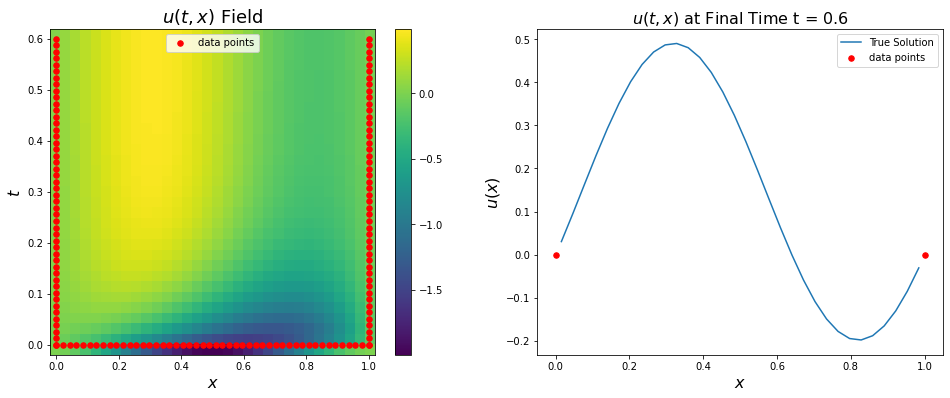

In [6]:
""" get the true solution first for n_test data points """
data.mode = 'solver'
data.get_pde_solution()
data.prep_data()

ext = 0.02
fig = plt.figure(figsize=(16, 6))
ax0 = fig.add_subplot(121)
pos = ax0.imshow(data.u_true, aspect='auto', origin='lower', cmap='viridis',
                 interpolation='nearest', extent=(data.d_x[0]-ext, data.d_x[1]+ext, data.d_t[0]-ext, data.d_t[1]+ext))
fig.colorbar(pos, ax=ax0)
ax0.scatter(data.x_data, data.t_data, s=30, c='r', label='data points')
ax0.set_title('$u(t, x)$ Field', fontsize=18)
ax0.set_xlabel('$x$', fontsize=16)
ax0.set_ylabel('$t$', fontsize=16)
plt.legend()

ax1 = fig.add_subplot(122)
ax1.plot(data.x_test, data.u_true[-1,:], label='True Solution')
ax1.set_title(f'$u(t, x)$ at Final Time t = {data.d_t[1]}', fontsize=16)
ax1.scatter(data.x_data[data.t_data==data.d_t[1]], data.u_data[data.t_data==data.d_t[1]], s=30, c='r', label='data points')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
plt.legend()
plt.show()

In [7]:
""" set hyperparameters """
BATCH_SIZE = 128
NUM_EPOCHS = 2500
layers = [2, 32, 32, 1]        # fully-connected neural net architecture: input layer dim=2 for (t, x), output layer dim=1 for u
loss_coeff = [1.0, 0.1]        # coefficients for the loss terms: [loss_data_coeff, loss_residual_coeff]

""" instantiate equation-informed model """
model_sol = AdvDiff1dNN(data, layers, loss_coeff)

Trainable parameters:
Unet/biases_layer_1:0 , shape: [32]
Unet/weights_layer_1:0 , shape: [2, 32]
Unet/biases_layer_2:0 , shape: [32]
Unet/weights_layer_2:0 , shape: [32, 32]
Unet/biases_layer_output:0 , shape: [1]
Unet/weights_layer_output:0 , shape: [32, 1]




In [ ]:
model_sol.train(num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

  0%|          | 0/2500 [00:00<?, ?it/s]

Relative L2 error: 15.8%


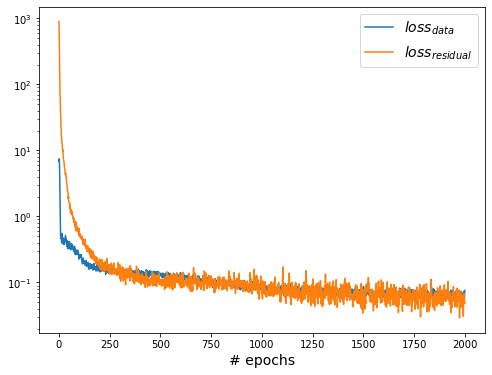

In [71]:
""" inference using the trained model """ 
t_pred, x_pred = np.meshgrid(data.t_test, data.x_test, sparse=False, indexing='ij')   # create a meshgrid
u_pred = model_sol.predict_U(t_pred.reshape(-1, 1), x_pred.reshape(-1, 1))            # flatten the data and push it through the neural network
u_pred = u_pred.reshape(data.t_test.shape[0], data.x_test.shape[0])                   # reshape model prediction

error = np.linalg.norm(data.u_true-u_pred, 2) / np.linalg.norm(data.u_true, 2)        # compute relative L2 error
print(f'Relative L2 error: {error*100:.1f}%')

""" plot the history of losses """
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(model.loss_dat_log, label='$loss_{data}$')
ax.plot(model.loss_res_log, label='$loss_{residual}$')
ax.set_xlabel('# epochs', fontsize=14)
ax.set_yscale('log')
plt.legend(fontsize=14)
plt.show()

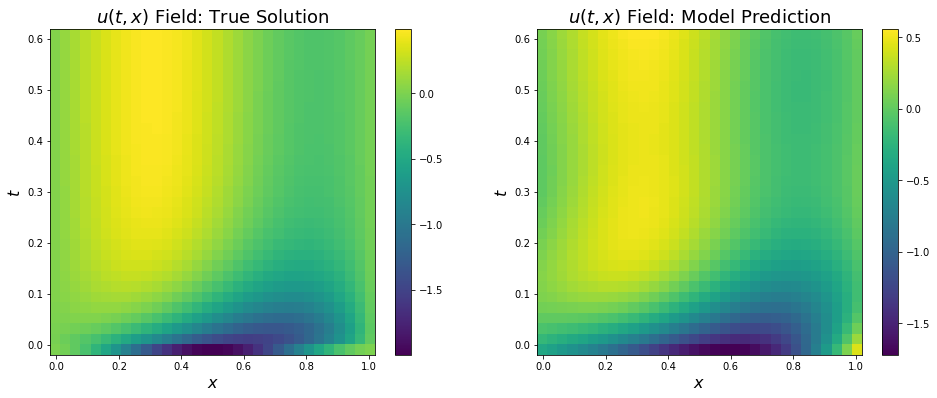

In [72]:
""" plot the true solution field """
fig = plt.figure(figsize=(16, 6))
ax0 = fig.add_subplot(121)
pos0 = plt.imshow(data.u_true, aspect='auto', origin='lower', cmap='viridis',
                  interpolation='nearest', extent=(data.d_x[0]-ext, data.d_x[1]+ext, data.d_t[0]-ext, data.d_t[1]+ext))
fig.colorbar(pos0, ax=ax0)
ax0.set_title(f'$u(t, x)$ Field: True Solution', fontsize=18)
ax0.set_xlabel('$x$', fontsize=16)
ax0.set_ylabel('$t$', fontsize=16)

""" plot model prediction """
ax1 = fig.add_subplot(122)
pos1 = plt.imshow(u_pred, aspect='auto', origin='lower', cmap='viridis',
                  interpolation='nearest', extent=(data.d_x[0]-ext, data.d_x[1]+ext, data.d_t[0]-ext, data.d_t[1]+ext))
fig.colorbar(pos1, ax=ax1)
ax1.set_title(f'$u(t, x)$ Field: Model Prediction', fontsize=18)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$t$', fontsize=16)
plt.show()

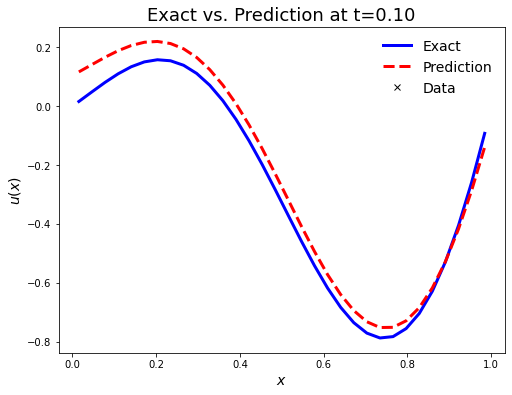

In [73]:
""" plot the solution for a specified time slice """
plt.figure(figsize=(8, 6))
sl = 5                        # available time slices are between [0, n_t]
t_slice = data.t_test[sl]
plt.plot(data.x_test, data.u_true[sl], 'b-', linewidth=3, label="Exact")
plt.plot(data.x_test, u_pred[sl], 'r--', linewidth=3, label="Prediction")
plt.plot(data.x_data[data.t_data==t_slice], data.u_data[data.t_data==t_slice], 'kx', linewidth=3, label="Data")
plt.legend(frameon=False, loc='upper right', fontsize=14)
plt.title(f'Exact vs. Prediction at t={t_slice[0]:0.2f}', fontsize=18)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$u(x)$', fontsize=14)
plt.show()

---
### Using model in inverse mode

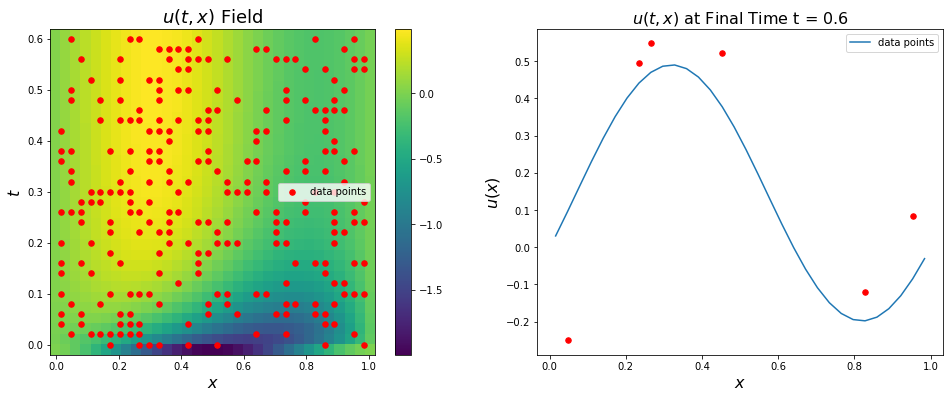

In [76]:
""" switch the mode in Data object to 'inverse' and generate required data optionally with noise """
data.mode = 'inverse'
data.prep_data()

fig = plt.figure(figsize=(16, 6))
ax0 = fig.add_subplot(121)
pos = ax0.imshow(data.u_true, aspect='auto', origin='lower', cmap='viridis',
                 interpolation='nearest', extent=(data.d_x[0]-ext, data.d_x[1]+ext, data.d_t[0]-ext, data.d_t[1]+ext))
fig.colorbar(pos, ax=ax0)
ax0.scatter(data.x_data, data.t_data, s=30, c='r', label='data points')
ax0.set_title('$u(t, x)$ Field', fontsize=18)
ax0.set_xlabel('$x$', fontsize=16)
ax0.set_ylabel('$t$', fontsize=16)
plt.legend()

ax1 = fig.add_subplot(122)
ax1.plot(data.x_test, data.u_true[-1,:], label='data points')
ax1.scatter(data.x_data[data.t_data==data.T], data.u_data[data.t_data==data.T], s=30, c='r')
ax1.set_title(f'$u(t, x)$ at Final Time t = {data.T}', fontsize=16)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
plt.legend()
plt.show()

In [77]:
""" set hyperparameters """
BATCH_SIZE = 128
NUM_EPOCHS = 2500
layers = [2, 32, 32, 1]        # fully-connected neural net architecture: input layer dim=2 for (t, x), output layer dim=1 for u
loss_coeff = [1.0, 0.1]        # coefficients for the loss terms: [loss_data_coeff, loss_residual_coeff]

""" instantiate equation-informed model """
model_inv = AdvDiff1dNN(data, layers, loss_coeff)

Trainable parameters:
Unet/biases_layer_1:0 , shape: [32]
Unet/weights_layer_1:0 , shape: [2, 32]
Unet/biases_layer_2:0 , shape: [32]
Unet/weights_layer_2:0 , shape: [32, 32]
Unet/biases_layer_output:0 , shape: [1]
Unet/weights_layer_output:0 , shape: [32, 1]
Pec_unknown:0 , shape: []




In [78]:
model_inv.train(num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

100%|██████████| 2500/2500 [03:16<00:00, 12.69it/s, Total Loss=0.0988]


Relative L2 error: 18.3%


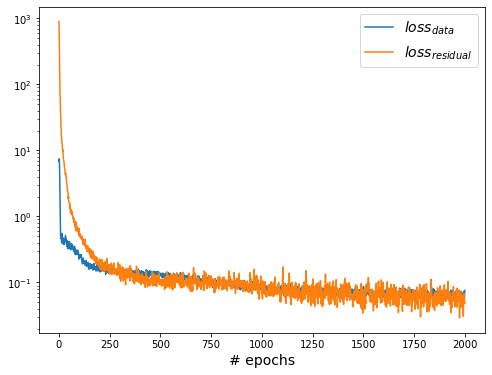

In [79]:
""" inference using the trained model """ 
t_pred, x_pred = np.meshgrid(data.t_test, data.x_test, sparse=False, indexing='ij')     # create a meshgrid
u_pred = model_inv.predict_U(t_pred.reshape(-1, 1), x_pred.reshape(-1, 1))              # flatten the data and push it through the neural network
u_pred = u_pred.reshape(data.t_test.shape[0], data.x_test.shape[0])                     # reshape model prediction

error = np.linalg.norm(data.u_true-u_pred, 2) / np.linalg.norm(data.u_true, 2)          # compute relative L2 error
print(f'Relative L2 error: {error*100:.1f}%')

""" plot the history of losses """
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(model.loss_dat_log, label='$loss_{data}$')
ax.plot(model.loss_res_log, label='$loss_{residual}$')
ax.set_xlabel('# epochs', fontsize=14)
ax.set_yscale('log')
plt.legend(fontsize=14)
plt.show()

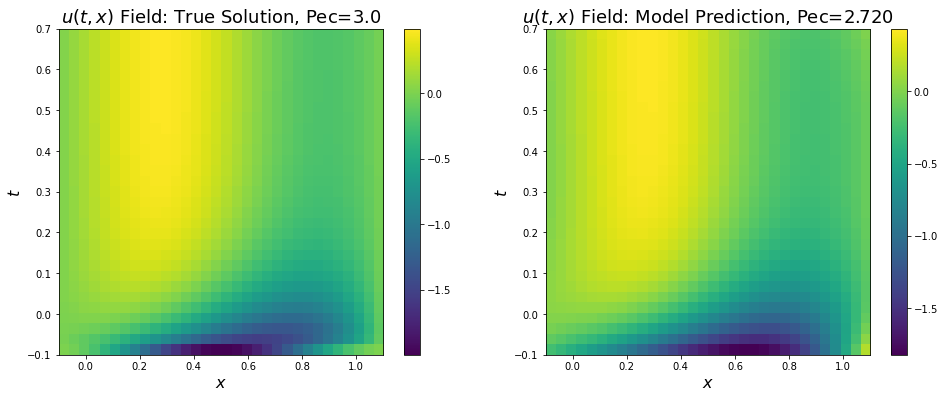

In [80]:
""" plot the true solution field """
fig = plt.figure(figsize=(16, 6))
ax0 = fig.add_subplot(121)
pos0 = plt.imshow(data.u_true, aspect='auto', origin='lower', cmap='viridis',
                  interpolation='nearest', extent=(data.d_x[0]-0.1, data.d_x[1]+0.1, data.d_t[0]-0.1, data.d_t[1]+0.1))
fig.colorbar(pos0, ax=ax0)
ax0.set_title(f'$u(t, x)$ Field: True Solution, Pec={data.Pec}', fontsize=18)
ax0.set_xlabel('$x$', fontsize=16)
ax0.set_ylabel('$t$', fontsize=16)

""" plot model prediction """
ax1 = fig.add_subplot(122)
pos1 = plt.imshow(u_pred, aspect='auto', origin='lower', cmap='viridis',
                  interpolation='nearest', extent=(data.d_x[0]-0.1, data.d_x[1]+0.1, data.d_t[0]-0.1, data.d_t[1]+0.1))
fig.colorbar(pos1, ax=ax1)
ax1.set_title(f'$u(t, x)$ Field: Model Prediction, Pec={model.Pec.numpy():.3f}', fontsize=18)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$t$', fontsize=16)
plt.show()

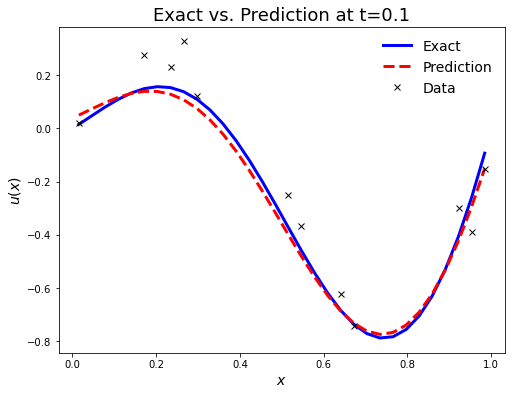

In [85]:
""" plot the solution for a specified time slice """
plt.figure(figsize=(8, 6))
sl = 5                        # time slices are between [0, n_t]
t_slice = data.t_test[sl]
plt.plot(data.x_test, data.u_true[sl], 'b-', linewidth=3, label="Exact")
plt.plot(data.x_test, u_pred[sl], 'r--', linewidth=3, label="Prediction")
plt.plot(data.x_data[data.t_data==t_slice], data.u_data[data.t_data==t_slice], 'kx', linewidth=3, label="Data")
plt.legend(frameon=False, loc='upper right', fontsize=14)
plt.title(f'Exact vs. Prediction at t={t_slice[0]}', fontsize=18)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$u(x)$', fontsize=14)
plt.show()